Evaluando modelos por tamaño de texto...


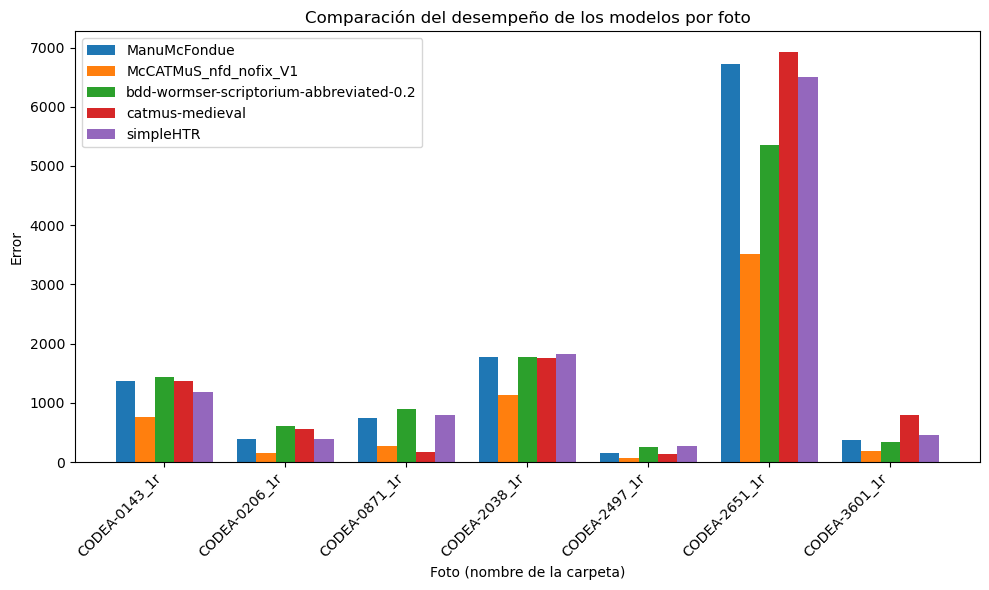

Evaluando modelos por edit distance...


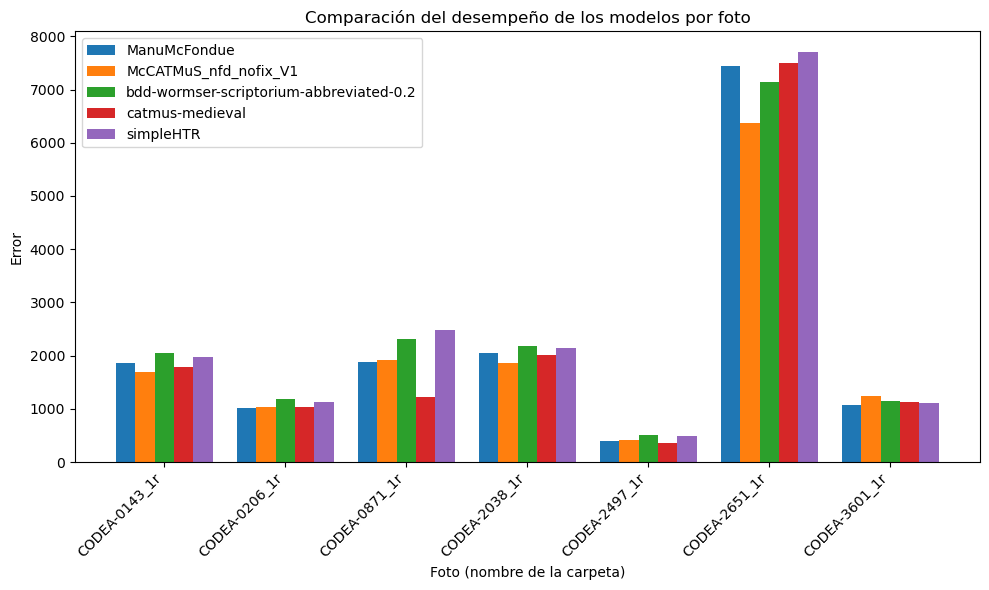

Evaluando modelos por normalized edit distance...


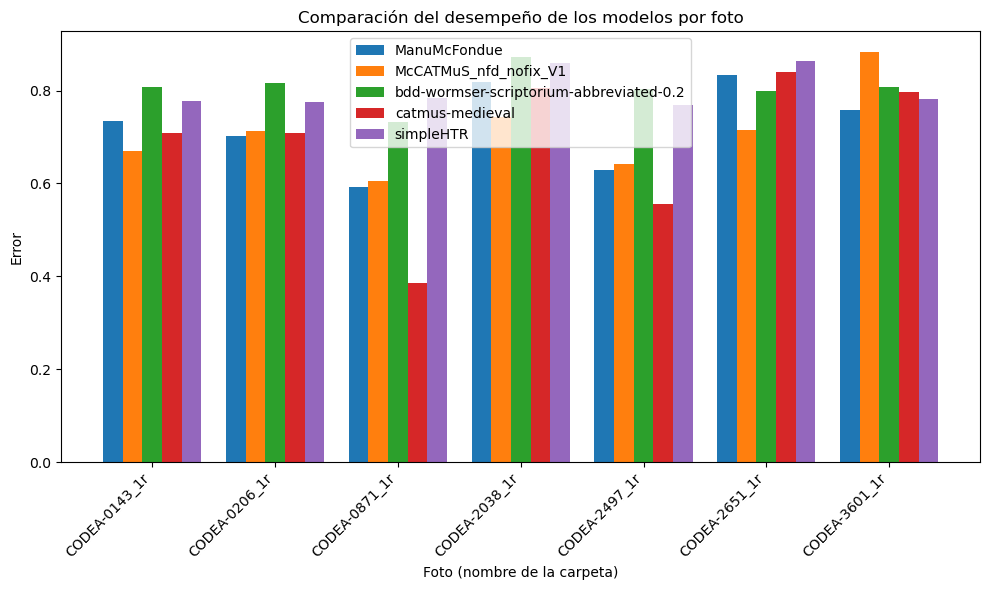

Evaluando modelos por word error...


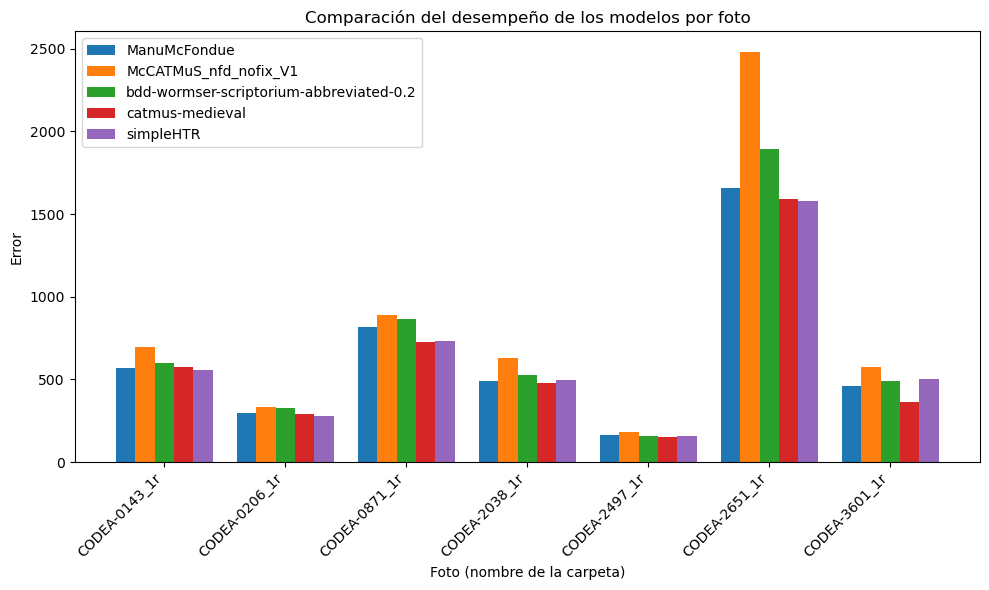

In [4]:
import os
import json
import glob
import matplotlib.pyplot as plt


def evaluate_models(metric_function):
    """
    Esta función recorre la carpeta 'model_outputs' y, para cada foto,
    busca el documento original en la carpeta 'Documents'. Luego, para cada modelo,
    calcula la métrica de error aplicando 'metric_function' al texto original y al texto predicho.
    Finalmente, imprime un gráfico comparativo de los errores de cada modelo por foto.
    """
    # Definir rutas relativas (asumiendo que el script se ejecuta desde la carpeta 'metrics')
    model_outputs_dir = "model_output"
    documents_dir = "Documents"
    
    # Diccionario para almacenar los resultados: { nombre_foto: { modelo: error, ... } }
    results = {}

    # Recorremos cada carpeta en model_outputs (cada carpeta corresponde a una foto)
    for photo_folder in os.listdir(model_outputs_dir):
        photo_folder_path = os.path.join(model_outputs_dir, photo_folder)
        if not os.path.isdir(photo_folder_path):
            continue

        # Extraer el ID del documento: todo lo que está antes del guion bajo
        doc_id = photo_folder.split('_')[0]
        json_file = os.path.join(documents_dir, f"{doc_id}.json")
        if not os.path.exists(json_file):
            print(f"Archivo JSON no encontrado para {doc_id}")
            continue

        # Cargar el JSON que contiene la información de las páginas
        with open(json_file, 'r', encoding='utf-8') as f:
            pages = json.load(f)

        # Buscar la página cuyo "image_url" contenga el nombre exacto de la carpeta (por ejemplo, "CODEA-0143_r")
        original_text = None
        for page in pages:
            if photo_folder in page.get("image_url", ""):
                original_text = page.get("paleographic_text", "")
                break

        if original_text is None:
            print(f"No se encontró la página para {photo_folder} en {json_file}")
            continue

        # Inicializar el diccionario de resultados para la foto
        results[photo_folder] = {}

        # Recorrer cada archivo .txt dentro de la carpeta de la foto
        txt_files = glob.glob(os.path.join(photo_folder_path, "*.txt"))
        for txt_file in txt_files:
            model_name = os.path.splitext(os.path.basename(txt_file))[0]
            with open(txt_file, 'r', encoding='utf-8') as f:
                predicted_text = f.read()
            # Calcular el error usando la función de métrica proporcionada
            error = metric_function(original_text, predicted_text)
            results[photo_folder][model_name] = error

    # Generar el gráfico comparativo
    # Obtenemos la lista de fotos (carpetas) y la lista de modelos (todos los que aparezcan)
    photos = list(results.keys())
    models_set = set()
    for photo in results:
        models_set.update(results[photo].keys())
    models = sorted(list(models_set))
    
    # Organizar los datos para cada modelo (se llena con 0 si algún modelo no tiene predicción para una foto)
    data = {model: [] for model in models}
    for photo in photos:
        for model in models:
            data[model].append(results[photo].get(model, 0))
    
    # Configurar parámetros para el gráfico de barras agrupadas
    x = range(len(photos))
    total_width = 0.8
    n_models = len(models)
    bar_width = total_width / n_models

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Dibujar las barras para cada modelo con un pequeño desplazamiento para evitar que se solapen
    for i, model in enumerate(models):
        # Calculamos el desplazamiento horizontal para cada grupo de barras
        offsets = [j - total_width/2 + i*bar_width + bar_width/2 for j in x]
        ax.bar(offsets, data[model], width=bar_width, label=model)
    
    ax.set_xlabel("Foto (nombre de la carpeta)")
    ax.set_ylabel("Error")
    ax.set_title("Comparación del desempeño de los modelos por foto")
    ax.set_xticks(x)
    ax.set_xticklabels(photos, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()

def size_comparison(texto_original, texto_predicho):
    # Calculamos la diferencia absoluta en la cantidad de caracteres
    return abs(len(texto_original) - len(texto_predicho))

def edit_distance(texto_original, texto_predicho):
    # Calculamos la distancia de edición entre ambos textos
    n = len(texto_original)
    m = len(texto_predicho)
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + (texto_original[i - 1] != texto_predicho[j - 1])
            )
    return dp[n][m]

def normalized_edit_distance(texto_original, texto_predicho):
    # Calculamos la distancia de edición entre ambos textos
    n = len(texto_original)
    m = len(texto_predicho)
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + (texto_original[i - 1] != texto_predicho[j - 1])
            )
    return dp[n][m]/len(texto_original)

from collections import Counter

def word_error(texto_original, texto_predicho):
    """
    Calcula el error entre dos textos basado en la diferencia de frecuencia de palabras.
    Se cuenta cuántas palabras faltan o sobran comparando el conteo de cada palabra en el texto original y en la predicción.
    """
    # Separar las palabras en cada texto
    palabras_original = texto_original.split()
    palabras_predicho = texto_predicho.split()
    
    # Contar las ocurrencias de cada palabra
    conteo_original = Counter(palabras_original)
    conteo_predicho = Counter(palabras_predicho)
    
    # Unir las palabras de ambos textos
    todas_palabras = set(conteo_original.keys()).union(conteo_predicho.keys())
    
    # Calcular la suma de las diferencias absolutas
    error = sum(abs(conteo_original.get(palabra, 0) - conteo_predicho.get(palabra, 0))
                for palabra in todas_palabras)
    return error

def normalized_word_error(texto_original, texto_predicho):
    """
    Calcula el error entre dos textos basado en la diferencia de frecuencia de palabras.
    Se cuenta cuántas palabras faltan o sobran comparando el conteo de cada palabra en el texto original y en la predicción.
    """
    # Separar las palabras en cada texto
    palabras_original = texto_original.split()
    palabras_predicho = texto_predicho.split()
    
    # Contar las ocurrencias de cada palabra
    conteo_original = Counter(palabras_original)
    conteo_predicho = Counter(palabras_predicho)
    
    # Unir las palabras de ambos textos
    todas_palabras = set(conteo_original.keys()).union(conteo_predicho.keys())
    
    # Calcular la suma de las diferencias absolutas
    error = sum(abs(conteo_original.get(palabra, 0) - conteo_predicho.get(palabra, 0))
                for palabra in todas_palabras)
    return error/len(palabras_original)

# Ejecución principal del script
if __name__ == "__main__":
    print("Evaluando modelos por tamaño de texto...")
    evaluate_models(size_comparison)

    print("Evaluando modelos por edit distance...")
    evaluate_models(edit_distance)

    print("Evaluando modelos por normalized edit distance...")
    evaluate_models(normalized_edit_distance)

    print("Evaluando modelos por word error...")
    evaluate_models(word_error)

    print("Evaluando modelos por normalized word error...")
    evaluate_models(normalized_word_error)
